In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

# Tải dữ liệu
input_path = '/kaggle/input'
train_file = os.path.join(input_path, 'child-mind-institute-problematic-internet-use/train.csv')
test_file = os.path.join(input_path, 'child-mind-institute-problematic-internet-use/test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

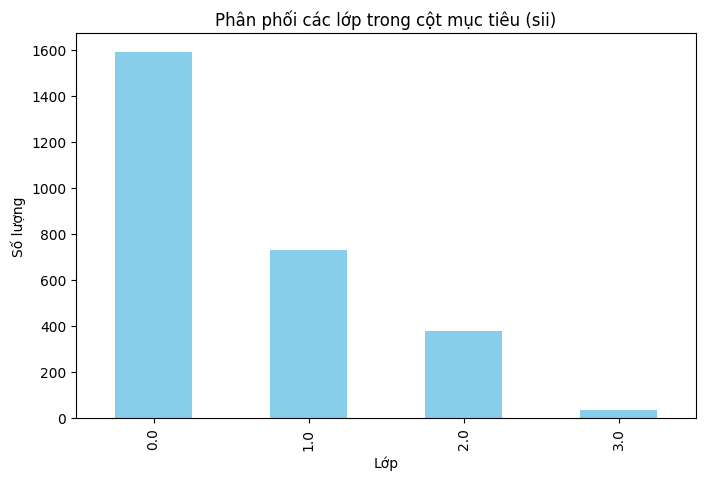

In [2]:
# Tách cột ID và cột mục tiêu
id_column = test_df['id']
test_df = test_df.drop(columns=['id'])
train_df = train_df.drop(columns=['id'])

# Xử lý cột mục tiêu
target = train_df.pop('sii')

# Loại bỏ các dòng có giá trị mục tiêu bị thiếu
train_df = train_df[target.notna()]
target = target[target.notna()]

# Biểu đồ kiểm tra cân bằng dữ liệu
plt.figure(figsize=(8, 5))
target.value_counts().plot(kind='bar', color='skyblue')
plt.title('Phân phối các lớp trong cột mục tiêu (sii)')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.show()

In [3]:
# Danh sách các features được chọn
selected_features = ['SDS-SDS_Total_Raw', 'Basic_Demos-Age', 'SDS-SDS_Total_T', 'Physical-Height', 'Physical-Weight', 
                     'PreInt_EduHx-computerinternet_hoursday', 'Physical-BMI', 'Physical-HeartRate', 'Physical-Systolic_BP', 
                     'CGAS-CGAS_Score', 'Physical-Diastolic_BP', 'PAQ_C-PAQ_C_Total', 'FGC-FGC_CU', 'BIA-BIA_LDM', 
                     'BIA-BIA_DEE', 'BIA-BIA_ICW', 'BIA-BIA_FFMI', 'BIA-BIA_BMC', 'BIA-BIA_LST', 'BIA-BIA_ECW', 
                     'BIA-BIA_SMM', 'FGC-FGC_SRR', 'BIA-BIA_FFM', 'BIA-BIA_BMR', 'BIA-BIA_Fat', 'FGC-FGC_SRL', 
                     'BIA-BIA_FMI', 'BIA-BIA_TBW', 'FGC-FGC_TL', 'CGAS-Season', 'FGC-FGC_PU', 'FGC-Season', 
                     'BIA-BIA_BMI', 'FGC-FGC_GSD', 'FGC-FGC_GSND', 'SDS-Season', 'Physical-Season', 'PAQ_C-Season', 
                     'PreInt_EduHx-Season', 'Basic_Demos-Enroll_Season', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Season']
# Lọc các features được chọn
train_df = train_df[selected_features]
test_df = test_df[selected_features]



In [4]:
#Mã hóa các biến phân loại
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col], _ = pd.factorize(train_df[col])
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col], _ = pd.factorize(test_df[col])

# Điền giá trị thiếu bằng trung vị
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)


# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)
y = target.values

# Cân bằng tập dữ liệu bằng SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X, y = smote.fit_resample(X, y)

# Chuyển cột mục tiêu sang dạng one-hot encoding
y = to_categorical(y, num_classes=4)

In [5]:
# Chia dữ liệu huấn luyện và kiểm tra
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Xây dựng mô hình mạng nơ-ron
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Lớp đầu ra cho bài toán phân loại đa lớp
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Biên dịch mô hình
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Thiết lập Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=2
)
# Đánh giá trên tập kiểm tra
val_predictions = model.predict(X_val)
val_auc = roc_auc_score(y_val, val_predictions, multi_class='ovr')
print(f"Validation AUC: {val_auc:.4f}")

val_labels = np.argmax(y_val, axis=1)
pred_labels = np.argmax(val_predictions, axis=1)
val_accuracy = np.mean(val_labels == pred_labels)
print(f"Validation Accuracy: {val_accuracy:.4f}")
# Huấn luyện lại trên toàn bộ dữ liệu
model.fit(
    X, y,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/100
80/80 - 6s - 72ms/step - accuracy: 0.4073 - loss: 1.5850 - val_accuracy: 0.4624 - val_loss: 1.2258
Epoch 2/100
80/80 - 1s - 7ms/step - accuracy: 0.4812 - loss: 1.2696 - val_accuracy: 0.5000 - val_loss: 1.1258
Epoch 3/100
80/80 - 1s - 8ms/step - accuracy: 0.5218 - loss: 1.1590 - val_accuracy: 0.5650 - val_loss: 1.0289
Epoch 4/100
80/80 - 1s - 7ms/step - accuracy: 0.5604 - loss: 1.0676 - val_accuracy: 0.6042 - val_loss: 0.9622
Epoch 5/100
80/80 - 1s - 8ms/step - accuracy: 0.5776 - loss: 1.0304 - val_accuracy: 0.6481 - val_loss: 0.8889
Epoch 6/100
80/80 - 1s - 8ms/step - accuracy: 0.5820 - loss: 0.9842 - val_accuracy: 0.6434 - val_loss: 0.8598
Epoch 7/100
80/80 - 1s - 7ms/step - accuracy: 0.6092 - loss: 0.9333 - val_accuracy: 0.6716 - val_loss: 0.8153
Epoch 8/100
80/80 - 1s - 7ms/step - accuracy: 0.6141 - loss: 0.9199 - val_accuracy: 0.6787 - val_loss: 0.7975
Epoch 9/100
80/80 - 1s - 8ms/step - accuracy: 0.6237 - loss: 0.8985 - val_accuracy: 0.6857 - val_loss: 0.7851
Epoch 10/

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


100/100 - 1s - 6ms/step - accuracy: 0.7734 - loss: 0.5985
Epoch 3/100
100/100 - 1s - 6ms/step - accuracy: 0.7873 - loss: 0.5791
Epoch 4/100
100/100 - 1s - 6ms/step - accuracy: 0.7831 - loss: 0.5844
Epoch 5/100
100/100 - 1s - 6ms/step - accuracy: 0.7886 - loss: 0.5773
Epoch 6/100
100/100 - 1s - 7ms/step - accuracy: 0.7898 - loss: 0.5734
Epoch 7/100
100/100 - 1s - 7ms/step - accuracy: 0.7955 - loss: 0.5657
Epoch 8/100
100/100 - 1s - 6ms/step - accuracy: 0.7978 - loss: 0.5617
Epoch 9/100
100/100 - 1s - 6ms/step - accuracy: 0.8021 - loss: 0.5589
Epoch 10/100
100/100 - 1s - 6ms/step - accuracy: 0.8071 - loss: 0.5490
Epoch 11/100
100/100 - 1s - 6ms/step - accuracy: 0.8029 - loss: 0.5549
Epoch 12/100
100/100 - 1s - 6ms/step - accuracy: 0.8115 - loss: 0.5305
Epoch 13/100
100/100 - 1s - 6ms/step - accuracy: 0.8033 - loss: 0.5408
Epoch 14/100
100/100 - 1s - 6ms/step - accuracy: 0.8137 - loss: 0.5375
Epoch 15/100
100/100 - 1s - 7ms/step - accuracy: 0.8152 - loss: 0.5229
Epoch 16/100
100/100 - 1s 

In [7]:
# Dự đoán trên tập kiểm tra
test_predictions = model.predict(X_test)
test_labels = np.argmax(test_predictions, axis=1)

# Chuẩn bị tệp nộp
submission = pd.DataFrame({'id': id_column, 'sii': test_labels})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Tệp nộp đã được lưu: /kaggle/working/submission.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Tệp nộp đã được lưu: /kaggle/working/submission.csv
